# Algorithme EM avec gestion d'Annotateurs Sparse

In [1]:
%matplotlib inline
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc

C:\Users\srotc_000\Anaconda3\lib\site-packages\matplotlib\__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def sigma(z):
    return 1/(1+np.exp(-z))

In [7]:
class EMSparse:
    """Classe qui encapsule l'apprentissage"""
    
    def __init__(self, D, R):
        """Constructeur"""
        
        self.D = D #Nombre de variables explicatives
        self.R = R #Nombre d'annotateurs
     
    
    def chargeData(self, path, recentrage = True):
        """Fonction qui charge les données avec path le chemin du fichier CSV. 
        Par default, on impose un recentrage des donnees"""
        
        data = pd.read_csv(path, delimiter = ";")
        self.trueLabel = np.array(data.ix[:,self.D])
        self.y = np.array(data.ix[:,self.D+1:]) #labels des annotateurs
        x = np.array(data.ix[:,0:self.D]) #variables explicatives
        if (recentrage):
            self.x = (x -np.mean(x,axis=0))/(np.std(x, axis=0))
        else:
            self.x = x
        self.N = self.y.shape[0] #Nombre de lignes
     
    
    def initMu(self):
        """Initialisation de mu"""
        
        self.mu = []
        for i in range(0,self.N):
            self.mu.append(np.nansum(self.y[i])/self.R)
    
    
    def ai(self):
        """Update du vecteur a (1xN)"""
        
        a = []
        for i in range(0,self.N):
            proda = 1
            for j in range(0,self.R):
                if (np.isnan(self.y[i][j])==False):
                    proda = proda*self.alpha[j]**(self.y[i][j])*(1-self.alpha[j])**(1-self.y[i][j])
            a.append(proda)
        self.a = a
    
    
    def bi(self):
        """Update du vecteur b (1xN)"""
        
        b = []
        for i in range(0,self.N):
            prodb = 1
            for j in range(0,self.R):
                if (np.isnan(self.y[i][j])==False):
                    prodb = prodb*self.beta[j]**(1-self.y[i][j])*(1-self.beta[j])**(self.y[i][j])
            b.append(prodb)
        self.b = b
       
    
    def pi(self):
        """Update du vecteur p (1xN)"""
        
        p = []
        for i in range(0,self.N):
            p.append(sigma(self.x[i].dot(self.w.T)))
        self.p = p
       
    
    def mui(self):
        """Update du vecteur mu (1xN). C'est l'étape E."""
        self.ai()
        self.bi()
        self.pi()
        mu = []
        for i in range(0,self.N):
            mu.append(self.a[i]*self.p[i]/(self.a[i]*self.p[i]+self.b[i]*(1-self.p[i])))
        self.mu = mu        
      
    
    def logLikelihood(self):
        """Calcul de la log-vraissemblance."""
        
        self.ai()
        self.bi()
        self.pi()
    
        #On calcule directement la log-vraissemblance.
        vraissemblance = 0
        for i in range(0,self.N):
            vraissemblance = vraissemblance + np.log((self.a[i]*self.p[i])+self.b[i]*(1-self.p[i]))
        return vraissemblance
    
    
    def alphaUpdate(self):
        """Update du vecteur alpha sensitivity (1xR)"""
        
        alpha = []
        for j in range(0,self.R):
            tmp1 = 0
            tmp2 = 0
            for i in range(0,self.N):
                if (np.isnan(self.y[i][j])==False):
                    tmp1 += self.mu[i]*self.y[i][j]
                    tmp2 += self.mu[i]
            alpha.append(tmp1/tmp2)
        self.alpha = alpha

        
    def betaUpdate(self):
        """Update du vecteur beta specificity (1xR)"""
        
        beta = []
        for j in range(0,self.R):
            tmp1 = 0
            tmp2 = 0
            for i in range(0,self.N):
                if (np.isnan(self.y[i][j])==False):
                    tmp1 += (1-self.mu[i])*(1-self.y[i][j])
                    tmp2 += 1-self.mu[i]
            beta.append(tmp1/tmp2)
        self.beta = beta

        
    def wUpdate(self):
        """Update du vecteur poids w (1xR)"""
        
        g = 0
        for i in range(0,self.N):
            g += (self.mu[i] - sigma(self.x[i].dot(self.w.T)))*self.x[i]

        H = np.zeros((self.D,self.D))
        for i in range(0,self.N):
            H -= sigma(self.x[i].dot(self.w.T))*(1-sigma(self.x[i].dot(self.w.T)))*((self.x[i].reshape(self.D,1))*(self.x[i].reshape(1,self.D)))
        self.w = self.w - self.eta*np.linalg.inv(H).dot(g)
    
    
    def score(self, seuil = 1/2):
        """Quel est le score d'apprentissage de notre modèle ?"""
        return np.mean(np.equal(self.trueLabel, np.array(self.mu)>seuil))
    
    
    def scoreMoy(self, seuil = 1/2):
        """Quel serait le score si on fesait naïvement la moyenne des avis des annotateurs ?"""
        return np.mean(np.equal(self.trueLabel, np.nanmean(self.y, axis = 1)>seuil))

    
    def train(self, maxIter = 1000, minIter = 200, eta = 0.01, epsilon = 0.00000001, graphe=True):
        """Fonction qui lance l'entrainement du modèle.
        La variable graphe sert à plotter la log-likelihood au fil des itérations.
        La log-likelihood devrait être croissante."""
        
        self.maxIter = maxIter
        self.eta = eta
        
        self.initMu()
        self.alphaUpdate()
        self.betaUpdate()
        self.w = np.random.rand(1,self.D)

        compteur = 0
        self.histLogLikelihood = []
        #while (np.linalg.norm(diff_w) > 0.001) : # Limite de convergence à decider
        while (compteur < maxIter):
            self.mui()
            self.alphaUpdate()
            self.betaUpdate()
            wOld = self.w
            self.wUpdate()
            wNew = self.w
            
            self.histLogLikelihood.append(self.logLikelihood())
            diffW = wOld - wNew
            if ((np.linalg.norm(diffW))/self.N < epsilon and compteur >= minIter) :
                print("SEUIL DE CONVERGENCE SUR W ATTEINT")
                print ("ITERATION : ", compteur)
                print("Vraissemblance : ", self.logLikelihood())
                print("Norme de diff_w : ", np.linalg.norm(diffW))
                print("Alpha : ", self.alpha)
                print("Beta : ", self.beta)
                break
            
            if (compteur % 100 == 0):
                print ("ITERATION : ", compteur)
                print("Vraissemblance : ", self.logLikelihood())
                print("Norme de diff_w : ", np.linalg.norm(diffW))
                print("Alpha : ", self.alpha)
                print("Beta : ", self.beta)
            compteur = compteur + 1
        
        if graphe:
            plt.plot(self.histLogLikelihood)
            plt.title('Log-vraissemblance au fil des itérations')
    
        
    def roc(self) :
        falsePR, truePR, threshold = roc_curve(self.trueLabel, self.mu) #falsePositiveRate and truePositiveRate
        falsePR1, truePR1, threshold1 = roc_curve(self.trueLabel, np.nanmean(self.y, axis = 1))
        roc_auc = auc(falsePR, truePR)
        roc_auc1 = auc(falsePR1, truePR1)
        plt.plot(falsePR, truePR, lw=2, label='ROC Modèle - AUC = %0.2f)'%(roc_auc))
        plt.plot(falsePR1, truePR1, lw = 2, label = 'ROC Moyenne - AUC = %0.2f)'%(roc_auc1))
        plt.legend()

ITERATION :  0
Vraissemblance :  [-1511.07872419]
Norme de diff_w :  4.10124164932
Alpha :  [array([ 0.81509518]), array([ 0.80937846]), array([ 0.60703467]), array([ 0.58794318]), array([ 0.52693787])]
Beta :  [array([ 0.93262398]), array([ 0.83966113]), array([ 0.62600669]), array([ 0.62387728]), array([ 0.58547267])]
SEUIL DE CONVERGENCE SUR W ATTEINT
ITERATION :  100
Vraissemblance :  [-1479.62787912]
Norme de diff_w :  1.98269121715e-07
Alpha :  [array([ 0.91496164]), array([ 0.87534947]), array([ 0.62177052]), array([ 0.57778585]), array([ 0.52256583])]
Beta :  [array([ 0.9447926]), array([ 0.84184509]), array([ 0.62049777]), array([ 0.60540968]), array([ 0.57634483])]


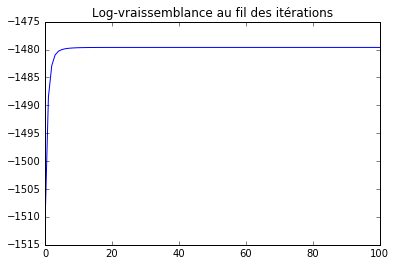

In [8]:
breast = EMSparse(10, 5)
breast.chargeData('Datasets/BreastCancer/DB_wdbcSparse.csv')
breast.train(maxIter = 500, minIter = 100, eta = 1, epsilon = 1e-8, graphe = True)

In [113]:
print("LE SCORE D'ENTRAINEMENT EST DE : ", breast.score())
print("LE SCORE NAIF DE MOYENNE DES ANNOTATEURS EST DE : ", breast.scoreMoy())

LE SCORE D'ENTRAINEMENT EST DE :  0.534261384169
LE SCORE NAIF DE MOYENNE DES ANNOTATEURS EST DE :  0.887521968366


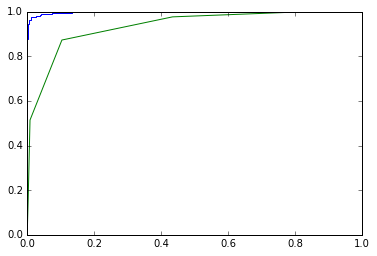

In [114]:
breast.roc()